# Two Stage Robust Optimization with CCG Algorithm

This is a toy example impelementation for the paper [Solving two-stage robust optimization problems using a column-and-constraint generation method](https://doi.org/10.1016/j.orl.2013.05.003) 

In [1]:
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt

In [2]:
class CCG_toy:
    def __init__(self, f, a, c, capacity, init_d, M = 1e5, epsilon = 1e-5, max_iter=100, OutputFlag=0):
        self.f = f
        self.a = a
        self.c = c
        self.capacity = capacity
        self.init_d = init_d

        self.n = self.c.shape[0]
        self.m = self.c.shape[1]

        self.UB = float("inf")
        self.LB = float("-inf")
        self.M = M
        self.epsilon = epsilon
        self.k = 0
        self.max_iter = max_iter
        self.lb_set = []
        self.ub_set = []

        self.OutputFlag = OutputFlag

        self.initialize_model()

    def initialize_model(self):
        
        # Master problem
        self.MP = gp.Model("CC&G Master")
        self.y = self.MP.addVars(range(self.n), vtype=gp.GRB.BINARY, name="y")
        self.z = self.MP.addVars(range(self.n), lb=0, vtype=gp.GRB.CONTINUOUS, name="z")
        self.x_SP = self.MP.addVars(range(self.n), range(self.m), lb=0, vtype=gp.GRB.CONTINUOUS, name="x_SP")
        self.yita = self.MP.addVar(vtype=gp.GRB.CONTINUOUS, name="yita")
        
        self.MP_Obj = gp.quicksum(self.f[i] * self.y[i] + self.a[i] * self.z[i] for i in range(self.n))
        self.MP_Obj = self.MP_Obj + self.yita
        self.MP.setObjective(self.MP_Obj, gp.GRB.MINIMIZE)
        
        self.MP.addConstrs((self.z[i] <= self.capacity*self.y[i] for i in range(self.n)), "z(i) <= 800*y(i)")
        self.MP.addConstr(sum(self.z[i] for i in range(self.n)) >= 772, "sum_z >= 772")
        for i in range(self.n):
            row_sum_x = sum(self.x_SP[i,j] for j in range(self.m))
            self.MP.addConstr(row_sum_x <= self.z[i], name=f"sum_x_{i} <= z{i}")
        for j in range(self.m):
            col_sum_x = sum(self.x_SP[i,j] for i in range(self.n))
            self.MP.addConstr(col_sum_x >= self.init_d[j], name=f"sum_x_{j} >= opt_d{j}")
        
        # Adversarial problem
        self.SP = gp.Model("CC&G Sub")
        self.x = self.SP.addVars(range(self.n), range(self.m), lb=0, ub=gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="x")
        self.g = self.SP.addVars(range(self.n), lb=0, ub=1, vtype=gp.GRB.CONTINUOUS, name="g")
        self.d = self.SP.addVars(range(self.m), lb=0, ub=gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="d")
        
        self.SP.addConstrs(self.d[j] == self.init_d[j] + 40 * self.g[j] for j in range(self.m))
        self.SP.addConstr(sum(self.g[i] for i in range(self.n)) <= 3)
        self.SP.addConstr(sum(self.g[i] for i in range(self.n)) <= 1.8)
        self.SP.addConstr(self.g[0] + self.g[1] <= 1.2)

    def solve_master(self):
        if self.OutputFlag:
            print("---------------------")
            print(f"       MP {self.k}          ")
            print("---------------------")
        # Solve the master problem
        self.MP.optimize()
        # Get the optimal value of z
        z_opt = np.array([self.z[i].X for i in range(self.n)])
        # Update the lower bound
        self.LB = max(self.LB,self.MP.objVal)
        self.lb_set.append(self.LB)
        return z_opt
        
    def solve_subproblem(self, z_opt):
        if self.OutputFlag:
            print("---------------------")
            print(f"       SP {self.k}          ")
            print("---------------------")

        # Set subproblem constraints and objective
        if self.k > 0:
            for sp in self.sp_constraints:
                self.SP.remove(sp)
            for v in self.sp_variables:
                self.SP.remove(v)
            self.SP.update()

        # KKT constraints
        pi = self.SP.addVars(range(self.n), lb=-gp.GRB.INFINITY, ub=0, vtype=gp.GRB.CONTINUOUS, name="pi")
        theta = self.SP.addVars(range(self.m), lb=-gp.GRB.INFINITY, ub=0, vtype=gp.GRB.CONTINUOUS, name="theta")
        v = self.SP.addVars(range(self.n), vtype=gp.GRB.BINARY, name="v")
        w = self.SP.addVars(range(self.m), vtype=gp.GRB.BINARY, name="w")
        h = self.SP.addVars(range(self.n), range(self.m), vtype=gp.GRB.BINARY, name="h")
        self.sp_variables = [pi, theta, v, w, h]
        
        sp1 = self.SP.addConstrs(sum(self.x[i,j] for j in range(self.m)) <= z_opt[i] for i in range(self.n))
        sp2 = self.SP.addConstrs(sum(self.x[i,j] for i in range(self.n)) >= self.d[j] for j in range(self.m))
        sp3 = self.SP.addConstrs(pi[i] - theta[j] <= self.c[i][j] for i in range(self.n) for j in range(self.m))
        sp4 = self.SP.addConstrs(-pi[i] <= self.M*v[i] for i in range(self.n))
        sp5 = self.SP.addConstrs(z_opt[i] - sum(self.x[i,j] for j in range(self.m)) <= self.M*(1-v[i]) for i in range(self.n) for j in range(self.m))
        sp6 = self.SP.addConstrs(-theta[j] <= self.M*w[j] for j in range(self.m))
        sp7 = self.SP.addConstrs(sum(self.x[i,j] for i in range(self.n)) - self.d[j] <= self.M*(1-w[j]) for j in range(self.m))
        sp8 = self.SP.addConstrs(self.x[i,j] <= self.M*h[i,j] for i in range(self.n) for j in range(self.m))
        sp9 = self.SP.addConstrs(self.c[i][j] - pi[i] + theta[j] <= self.M*(1-h[i,j]) for i in range(self.n) for j in range(self.m))
        self.sp_constraints = [sp1, sp2, sp3, sp4, sp5, sp6, sp7, sp8, sp9]
   
        SP_Obj = sum(self.c[i][j]*self.x[i,j] for i in range(self.n) for j in range(self.m))
        self.SP.setObjective(SP_Obj, gp.GRB.MAXIMIZE)
            
        self.SP.optimize()

    def plot_results(self):
        plt.figure()
        plt.plot(range(self.k), self.lb_set, label="lower bound")
        plt.plot(range(self.k), self.ub_set, label="upper bound")
        plt.xlabel("iteration")
        plt.ylabel("value")
        plt.legend()
        plt.show()

    def optimize(self):
        print("Starting optimization")
        self.MP.Params.OutputFlag = self.OutputFlag
        self.SP.Params.OutputFlag = self.OutputFlag
        while (self.UB - self.LB > self.epsilon):
            print(f"Iteration {self.k} with UB: {self.UB} and LB: {self.LB}")
            z_opt = self.solve_master()
            self.solve_subproblem(z_opt)

            if self.SP.Status != gp.GRB.INFEASIBLE:
                opt_d = np.array([self.d[j].X for j in range(self.m)])
                y_stage1 = np.array([self.y[i].X for i in range(self.n)])
                z_stage1 = np.array([self.z[i].X for i in range(self.n)])
                    
            if self.SP.status == gp.GRB.OPTIMAL:
                # Update the upper bound
                self.UB = min(self.UB,self.SP.ObjVal + sum(self.f[i]*y_stage1[i] + self.a[i]*z_stage1[i] for i in range(self.n)))
                self.ub_set.append(self.UB)
                    
                var_name = f'x{self.k}'
                new_x = self.MP.addVars(range(self.n), range(self.m), lb=0, vtype=gp.GRB.CONTINUOUS, name=var_name)
                    
                sum_cx = 0
                for i in range(self.n):
                    for j in range(self.m):
                        sum_cx += self.c[i,j]*new_x[i,j]
                self.MP.addConstr(self.yita >= sum_cx, name="yita >= sum_cx")
                    
                for i in range(self.n):
                    row_sum_x = sum(new_x[i,j] for j in range(self.m))
                    self.MP.addConstr(row_sum_x <= self.z[i], name=f"sum_x_{i} <= z{i}")
                    
                for j in range(self.m):
                    col_sum_x = sum(new_x[i,j] for i in range(self.n))
                    self.MP.addConstr(col_sum_x >= opt_d[j], name=f"sum_x_{j} >= opt_d{j}")
                    
                self.MP.update()
                    
            elif self.SP.Status == gp.GRB.UNBOUNDED:
                # Update the upper bound
                self.UB = min(self.UB,self.SP.ObjVal)
                self.ub_set.append(self.UB)
                    
                var_name = f'x{self.k}'
                self.MP.addVars(range(self.n), range(self.m), lb=0, vtype=gp.GRB.CONTINUOUS, name=var_name)
                    
                for i in range(self.n):
                    row_sum_x = sum(new_x[i,j] for j in range(self.m))
                    self.MP.addConstr(row_sum_x <= self.z[i], name=f"sum_x_{i} <= z{i}")
                    
                for j in range(self.m):
                    col_sum_x = sum(new_x[i,j] for i in range(self.n))
                    self.MP.addConstr(col_sum_x >= opt_d[j], name=f"sum_x_{j} >= opt_d{j}")
                
            else:
                print("No solution due to infeasibility")
                break

            if self.k > self.max_iter:
                break
            self.k = self.k + 1

        print(f"Optimization complete in {self.k} iterations. UB: {self.UB}, LB: {self.LB}")
        self.plot_results()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-16
Starting optimization
Iteration 0 with UB: inf and LB: -inf
Iteration 1 with UB: 35238.0 and LB: 14296.0
Iteration 2 with UB: 33696.0 and LB: 33680.0
Optimization complete in 3 iterations. UB: 33680.0, LB: 33680.0


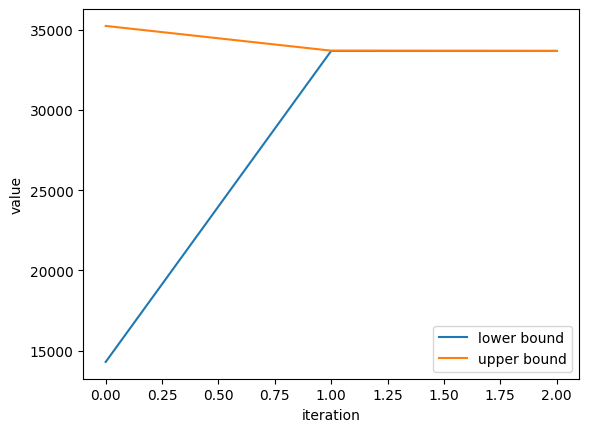

In [3]:
f = np.array([400,414,326])
a = np.array([18,25,20])
c = np.array([[22,33,24],
              [33,23,30],
              [20,25,27]])
capacity = 800
init_d = np.array([206,274,220])

ccg = CCG_toy(f, a, c, capacity, init_d)
ccg.optimize()